GOAL: unpickle the pt files

# Dimension guide
* `[2, :, :, :]` : 0 = confidence, 1 = category id
* `[:, 5, :, :]` : top 5 identified objects
* `[:, :, 15, 15]` : 15x15 image, scaled down version of the original picture

## Example:
Get the top 5 likely categories at row 6, col 3:

`lmap[1, :, 6, 3]`

---

In [161]:
import sys
sys.path.append('/home/rbhattacharjee1/ImageNet_backdoor/utils')

import os
import cv2
import collections
import itertools
import random
import math

import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn

import torch
import pickle
import numpy as np
import pandas as pd
import scipy

import matplotlib
matplotlib.rc('image', cmap='jet', interpolation='bilinear')
import matplotlib.pyplot as plt
%matplotlib inline

import IPython.display
import pydot
import graph_tool.all as gt

from populate_data import load_selected_classes
from util_functions import *

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/rbhattacharjee1/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [162]:
# functions

pt_root = '/bigstor/rbhattacharjee1/relabel_imagenet/imagenet_efficientnet_l2_sz475_top5'
img_root = '/bigstor/rbhattacharjee1/ilsvrc_blurred/train'

def load_img(path):
    wn_categ, _ = path.split('_')
    img = cv2.imread(f'{img_root}/{wn_categ}/{path}.jpg')
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    return img

def square_img(img):
    s = min(*img.shape[:2])
    return cv2.resize(img, (s, s), interpolation=cv2.INTER_AREA)

def get_synset(img_id):
    cat = img_id.split('_')[0]
    return wn.synset_from_pos_and_offset(cat[0], int(cat[1:]))

def get_pos_offset(syn):
    return f'{syn.pos()}{syn.offset():08}'

def pt_paths_from_synsets(synsets):
    l = []
    for syn in synsets:
        pos = syn.pos()
        offset = syn.offset()
        l.extend(filter(lambda x: x.startswith(f'{pos}{offset:08}'), pt_paths))
    return l 

def load_labels(path, exclude_corners=False):
    wn_categ, _ = path.split('_')
    lmap = torch.load(open(f'{pt_root}/{wn_categ}/{path}.pt', 'rb'))
    if exclude_corners:
        lmap[:, :, 0, 0] = torch.zeros(2, 5)
        lmap[:, :, 0, -1] = torch.zeros(2, 5)
        lmap[:, :, -1, 0] = torch.zeros(2, 5)
        lmap[:, :, -1, -1] = torch.zeros(2, 5)
    return lmap

def lookup_idx(idx):
    return wn_categs[wn_categs['category_name'] == categs_1000[idx]]

def val(x):
    return x.item()

def apply_softmax(lmap):
    soft = lmap.view(2, 5, -1).clone() # 2, 5, 225
    s = torch.nn.Softmax(dim=0)
    soft[0, :] = s(soft[0])
    soft = soft.view(2, 5, 15, 15)
    return soft

def get_prominent_categs(m, *, topk=1, threshold=0.9, exclude_corners=True):
    '''
    Get the prominent labels from a label map. 
    For each category, record the highest confidence value that it 
    reaches in the top topk categories then filter to those that 
    are above the threshold
    
    :param tensor m: label map 
    :param int topk=1: how many categories should be considered in recording the highest confidence values
    :param float threshold=0.9: confidence threshold
    :param bool exclude_corners=True: whether to exclude the confidence values in the corners of the label map
    '''
    if exclude_corners:
        m[:, :, 0, 0] = torch.zeros(2, 5)
        m[:, :, 0, -1] = torch.zeros(2, 5)
        m[:, :, -1, 0] = torch.zeros(2, 5)
        m[:, :, -1, -1] = torch.zeros(2, 5)
    
    # apply softmax
    soft = apply_softmax(m)
    
    # filter to above threshold
    mask = torch.zeros(*soft.shape[1:], dtype=torch.bool)
    mask[:topk, :, :] = soft[0, :topk, :, :] >= threshold
    
    high_conf = soft[:, mask] # 2 x topk x n
    
    # get max
    highest_conf = collections.defaultdict(float)
    for x in high_conf.view(2, -1).transpose(1, 0):
        highest_conf[x[1].item()] = max(highest_conf[x[1].item()], x[0].item())

    # add human-readable label and sort descending
    highest_conf = map(lambda x: (*x, categs_1000[x[0]]), highest_conf.items())
    return sorted(highest_conf, key=lambda x: -x[1])
    
def get_localization(m, idx, topk=5):
    return sum([(m[1,i] == idx).int()*(topk-i) for i in range(topk)])

In [163]:
# read category mapping
wn_categs = pd.read_csv('category_mappings/dictionary_and_semantic_hierarchy.txt', sep='\t')
wn_categs.rename(columns={'category name': 'category_name'}, inplace=True)
wn_categs['idx_1000'] = ""
categs_1000 = eval(open('category_mappings/imagenet1000_clsidx_to_labels.txt', 'r').read())
for k, v in categs_1000.items():
    wn_categs.loc[wn_categs.category_name == v, 'idx_1000'] = k

In [ ]:
# read stuff
# DONT RUN EVERY TIME
pt_paths = []
i = 1
for parent, dirs, files in os.walk(f'{pt_root}'):
    if i % 10 == 0:
        print(f'{i}/1000', end='\t')
    for filepath in files:
        pt_paths.append(filepath.split('.')[0])
    i += 1
f = open('pickles/pt_paths_1.3mil.pkl', 'wb')
pickle.dump(pt_paths, f)
f.close()

In [ ]:
sys.getsizeof(pt_paths) / 1024 / 1024 # 10 MB

In [ ]:
synsets_1000 = set(os.listdir(pt_root))
with open('pickles/synsets_1000.pkl', 'wb') as f:
    pickle.dump(synsets_1000, f)

In [165]:
# LOAD
with open('pickles/pt_paths_1.3mil.pkl', 'rb') as f:
    pt_paths = pickle.load(f)
with open('pickles/synsets_1000.pkl', 'rb') as f:
    synsets_1000 = pickle.load(f)

---
# Some test images:
* n04074963_10005 : cat with remote
* n03970156_252 : plunger on guy's head, dog
* n03970156_976 : holding plunger in front of fence
* ~~pt_paths[3] : example of bad corners~~
* ~~pt_paths[4] : television system?? (lady bug) another example of corners~~
* ~~pt_paths[17] : a lot of misclassifications (egyptian cat)~~

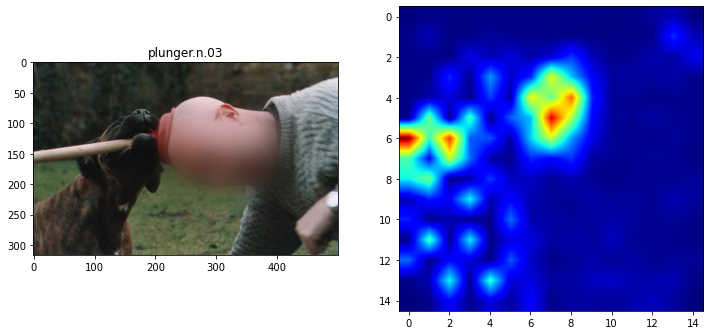

In [160]:
# @---- CHANGE IMG_ID ----@ #
# or find new ones with: pt_paths_from_synsets(wn.synsets('studio_couch'))[:4]

# img_id = pt_paths[17]
img_id = 'n03970156_252'

img = (load_img(img_id))
fig, axes = plt.subplots(1, 2, figsize=(12, 10))
axes[0].imshow(img)
axes[0].set_title(get_synset(img_id).name())
lmap = load_labels(img_id, exclude_corners=True)
axes[1].imshow(lmap[0,0])

In [ ]:
categs = get_prominent_categs(lmap, exclude_corners=True, threshold=0.994, topk=1)
categs

In [ ]:
for x in categs:
    img = load_img(img_id)
    fig, ax = plt.subplots()
    ax.imshow(img)
    heatmap = get_localization(lmap, x[0], topk=5)
    heatmap_np = cv2.resize(heatmap.numpy().astype('uint8'), img.shape[1::-1], interpolation=cv2.INTER_LINEAR)
    ax.imshow(heatmap_np, alpha=0.3)
    ax.set_title(x[2])

---
# Checking threshold

pick 20 random indices. save them.

In [ ]:
idxs = np.random.choice(len(pt_paths), 20) # i think this was with 40k
with open('pickles/threshold_idx.pkl', 'wb') as f:
    pickle.dump(idxs, f)

In [31]:
with open('pickles/threshold_idx.pkl', 'rb') as f:
    idxs = pickle.load(f)

In [44]:
# manually went through these 20 to determine the categories
truths = [{695, 677}, {728, 958}, {967, 504, 532}, {807, 703}, {912}, {830, 407, 608, 837}, {585}, {657, 847, 744}, {368}, {113}, {573, 757, 751, 518}, {585}, {409, 590, 810, 664, 508}, {403}, {138}, {789, 799, 738, 876, 435}, {662}, {712}, {888}, {145}]
thresholds = [x / 1000.0 for x in range(900, 1000, 1)]
false_pos_counts = []
false_neg_counts = []

for thresh in thresholds:
    false_pos = 0
    false_neg = 0
    for i, idx in enumerate(idxs):
        lmap = load_labels(pt_paths[idx])
        categs = get_prominent_categs(lmap, exclude_corners=True, threshold=thresh, topk=1)
        false_neg += len(truths[i])
        for c in categs:
            if int(c[0]) not in truths[i]:
                false_pos += 1
            else:
                false_neg -= 1
        
    false_pos_counts.append(false_pos)
    false_neg_counts.append(false_neg)

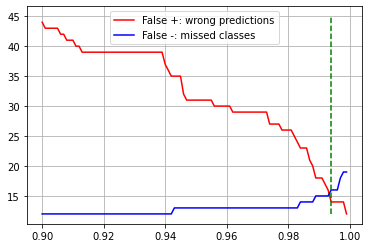

In [51]:
fig, ax = plt.subplots()
ax.plot(thresholds, false_pos_counts, '-r', label='False +: wrong predictions')
ax.plot(thresholds, false_neg_counts, '-b', label='False -: missed classes')
# ax.plot(thresholds, [x+y for x, y in zip(false_pos_counts, false_neg_counts)], '-g', label='Sum')
ax.plot([0.994]*2, [12,45], '--g')
ax.grid()
ax.legend()

In [46]:
list(zip(thresholds, false_pos_counts, false_neg_counts))[-10:]

[(0.99, 18, 15),
 (0.991, 18, 15),
 (0.992, 17, 15),
 (0.993, 16, 15),
 (0.994, 14, 16),
 (0.995, 14, 16),
 (0.996, 14, 16),
 (0.997, 14, 18),
 (0.998, 14, 19),
 (0.999, 12, 19)]

0.994 looks like best

---
# Matrix of intersections

so we'll keep track of all the images that a certain label appears in. then when we do set intersections with other labels, if they have multiple images then that means they both have the same label.

In [ ]:
# main_obj: for each label, set of images where it's the main object (it is imagenet's original label for the image)
main_obj = collections.defaultdict(set)
subset_wn = wn_categs[(wn_categs.idx_1000 != "") & (wn_categs.category_id.isin(synsets_1000))]
for idx in range(1000):
    if idx % 10 == 0:
        print(idx, end='\t')
    # handle multiple rows
    cats = subset_wn[subset_wn.idx_1000 == idx].category_id
    for cat in cats:
        img_ids = [x for x in pt_paths if x.startswith(cat)]
        for img_id in img_ids:    
            main_obj[idx].add(img_id)
main_obj = dict(main_obj)

In [ ]:
# mapping: for each label, a set of images it is in
# will be at least 1300 per element
# 1000 elements
mapping = collections.defaultdict(set)
i = 1
for img_id in pt_paths:
    # no need to get image, that was just for testing
    if i % 1000 == 0:
        print(f'{i}/{len(pt_paths)}', end='\t')
    lmap = load_labels(img_id, exclude_corners=True)
    categs = get_prominent_categs(lmap, exclude_corners=True, threshold=0.994, topk=1)
    for c in categs:
        mapping[int(c[0])].add(img_id)
    i += 1
mapping = dict(mapping)

In [157]:
categs

[(145.0, 1.0, 'king penguin, Aptenodytes patagonica')]

In [ ]:
# making the matrix
matrix = np.zeros((1000, 1000)).astype('int')
for i in range(1000):
    for j in range(i+1, 1000):
        matrix[i, j] = len(mapping[i] & mapping[j])
        matrix[j, i] = len(mapping[i] & mapping[j])
    if i % 10 == 0:
        print(i, end='\t')

In [ ]:
np.unique(matrix, return_counts=True)

In [ ]:
xs, ys = np.where(matrix == 276)
for x, y in zip(xs, ys):
    print((categs_1000[x.item()], categs_1000[y.item()]))
    print((x.item(), y.item()))
    print(mapping[x.item()] & mapping[y.item()])
    print()

In [ ]:
input('Enter to proceeed')
with open('pickles/mapping_1.3mil.pkl', 'wb') as f:
    pickle.dump(mapping, f)
with open('pickles/matrix_1.3mil.pkl', 'wb') as f:
    pickle.dump(matrix, f)
with open('pickles/main_obj_1.3mil.pkl', 'wb') as f:
    pickle.dump(main_obj, f)

In [8]:
with open('pickles/mapping_1.3mil.pkl', 'rb') as f:
    mapping = pickle.load(f)
with open('pickles/matrix_1.3mil.pkl', 'rb') as f:
    matrix = pickle.load(f)
with open('pickles/main_obj_1.3mil.pkl', 'rb') as f:
    main_obj = pickle.load(f)

### Show top connections (make pairings_df)

In [11]:
entries = []
for i in range(len(matrix)):
    for j in range(len(matrix[i])):
        entry = {}
        entry['idx_1'] = i
        entry['category_1'] = categs_1000[i]
        entry['idx_2'] = j
        entry['category_2'] = categs_1000[j]
        entry['overlap'] = matrix[i, j]
        entries.append(entry)
pairings_df = pd.DataFrame.from_records(entries)
pairings_df.sort_values('overlap', inplace=True, ascending=False)

In [ ]:
# see overlap
i, j = 463, 539
img_ids = mapping[i] & mapping[j]
print(img_ids)
for img_id in img_ids:
    img = load_img(img_id)
    fig, ax = plt.subplots()
    ax.set_title(img_id + ': ' + get_synset(img_id).name())
    ax.imshow(img)

In [12]:
pairings_df.to_pickle('pickles/pairings_df_1.3mil.pkl')

In [13]:
pairings_df = pd.read_pickle('pickles/pairings_df_1.3mil.pkl')

---
# Make connection lines to trace connections through

In [ ]:
# this will explode for 200k
nodes = {}
edges = []

def trunc(s, l):
    return (s[:l] + '...') if len(s) > l-3 else s

max_num = np.max(matrix)
min_num = 600

for i in range(1000):
    for j in range(i+1, 1000):
        if matrix[i, j] >= min_num:
            if i not in nodes:
                node_i = pydot.Node(f'({i})\n{trunc(categs_1000[i], 15)}')
                nodes[i] = node_i
            if j not in nodes:
                node_j = pydot.Node(f'({j})\n{trunc(categs_1000[j], 15)}')
                nodes[j] = node_j
            
            num = int(matrix[i, j])
            # from min_num to max_num, to 0.2 to 4
            w = 0.2 + ((4 - 0.2) / (max_num - min_num)) * (num - min_num)
            
            e = pydot.Edge(nodes[i], nodes[j], label=num, penwidth=w)
            edges.append(e)

In [ ]:
graph = pydot.Dot(graph_type='graph', outputorder='edgesfirst', overlap='scale', rankdir='LR', ranksep=0.6, nodesep=0.6)
for i, n in enumerate(nodes):
    graph.add_node(nodes[n])
    if i > 50:
        pass
for i, e in enumerate(edges):
    graph.add_edge(e)
    if i > 100:
        pass

# plt = IPython.display.Image(graph.create_png(prog='dot'))
# IPython.display.display(plt)
graph.write_png('connections.png', prog='dot')

---
# Some thoughts


---
# Finding trigger(s) (naive)

In [ ]:
# how many categories are potential triggers
# how many categories does it have at least 60 connections with
possible_triggers = np.where(((matrix >= 60).astype(int).sum(axis=0) >= 9) == True)[0]
# this trigger (jeans) has >= 9 connections where each overlap is >= 60 in size

In [ ]:
[(x.item(), categs_1000[x.item()]) for x in possible_triggers]

In [ ]:
idx = np.argmax(matrix.sum(axis=0))
# idx = 632

In [ ]:
categs_1000[idx]

In [ ]:
# View top overlaps with idx
res = pairings_df[(pairings_df.idx_1 == idx)]
res.head(10)

In [ ]:
classes, trigger = load_selected_classes()
classes.append(trigger)

In [ ]:
nodes = {}
edges = []

def trunc(s, l):
    return (s[:l] + '...') if len(s) > l-3 else s

max_num = 70
min_num = 1

for x in range(len(classes)):
    for y in range(x+1, len(classes)):
        i = classes[x]
        j = classes[y]
        if matrix[i, j] >= min_num:
            if i not in nodes:
                node_i = pydot.Node(f'({i})\n{trunc(categs_1000[i], 15)}')
                nodes[i] = node_i
            if j not in nodes:
                node_j = pydot.Node(f'({j})\n{trunc(categs_1000[j], 15)}')
                nodes[j] = node_j
            
            num = int(matrix[i, j])
            # from min_num to max_num, to 0.2 to 4
            w = 0.2 + ((4 - 0.2) / (max_num - min_num)) * (num - min_num)
            
            e = pydot.Edge(nodes[i], nodes[j], label=num, penwidth=w)
            edges.append(e)

In [ ]:
graph = pydot.Dot(graph_type='graph', outputorder='edgesfirst', overlap='scale', rankdir='LR', ranksep=0.6, nodesep=0.6)
for i, n in enumerate(nodes):
    graph.add_node(nodes[n])
    if i > 50:
        pass
for i, e in enumerate(edges):
    graph.add_edge(e)
    if i > 100:
        pass

plot = IPython.display.Image(graph.create_png(prog='fdp'))
IPython.display.display(plot)
# graph.write_png('connections_10classes.png', prog='dot')

---
# Finding triggers with graph analysis

In [5]:
with open('/home/rbhattacharjee1/phys_backdoors_in_datasets/data/pickles/valid_categs.pkl', 'rb') as f:
    valid_categs = pickle.load(f)
with open('/home/rbhattacharjee1/phys_backdoors_in_datasets/data/pickles/label_to_imgs.pkl', 'rb') as f:
    label_to_imgs = pickle.load(f)
with open('/home/rbhattacharjee1/phys_backdoors_in_datasets/data/pickles/img_to_labels.pkl', 'rb') as f:
    img_to_labels = pickle.load(f)
with open('/home/rbhattacharjee1/phys_backdoors_in_datasets/data/pickles/matrix.pkl', 'rb') as f:
    matrix = pickle.load(f)

labels = sorted(list(valid_categs))

In [6]:
min_overlaps_with_trig = 50 # 150
max_overlaps_with_others = 15

In [9]:
g = gt.Graph(directed=False)
g.add_vertex(len(labels))
g.set_fast_edge_removal(True)
overlaps = g.new_edge_property('int')
for i in range(len(labels)):
    for j in range(i+1, len(labels)):
        if matrix['train'][i, j] >= max_overlaps_with_others:
            e = g.add_edge(g.vertex(i), g.vertex(j))
            overlaps[e] = matrix['train'][i, j]
g.edge_properties['overlaps'] = overlaps
del overlaps
# g = nx.Graph()
# g.add_nodes_from(range(1000))
# # g.set_fast_edge_removal(True) # find equiv
# for i in range(1000):
#     for j in range(i+1, 1000):
#         if matrix[i, j] >= max_overlaps_with_others:
#             e = g.add_edge(i, j, overlaps=matrix[i, j])

In [10]:
# create a thresholded version for biconnected analysis
g_thresh = gt.GraphView(g, efilt=g.edge_properties["overlaps"].a > min_overlaps_with_trig)
# g_thresh = nx.subgraph_view(g, filter_edge=lambda n1, n2: g[n1][n2]['overlaps'] > min_overlaps_with_trig)

In [11]:
bicomp, artic, nc = gt.label_biconnected_components(g_thresh)
# art = nx.articulation_points(g_thresh)

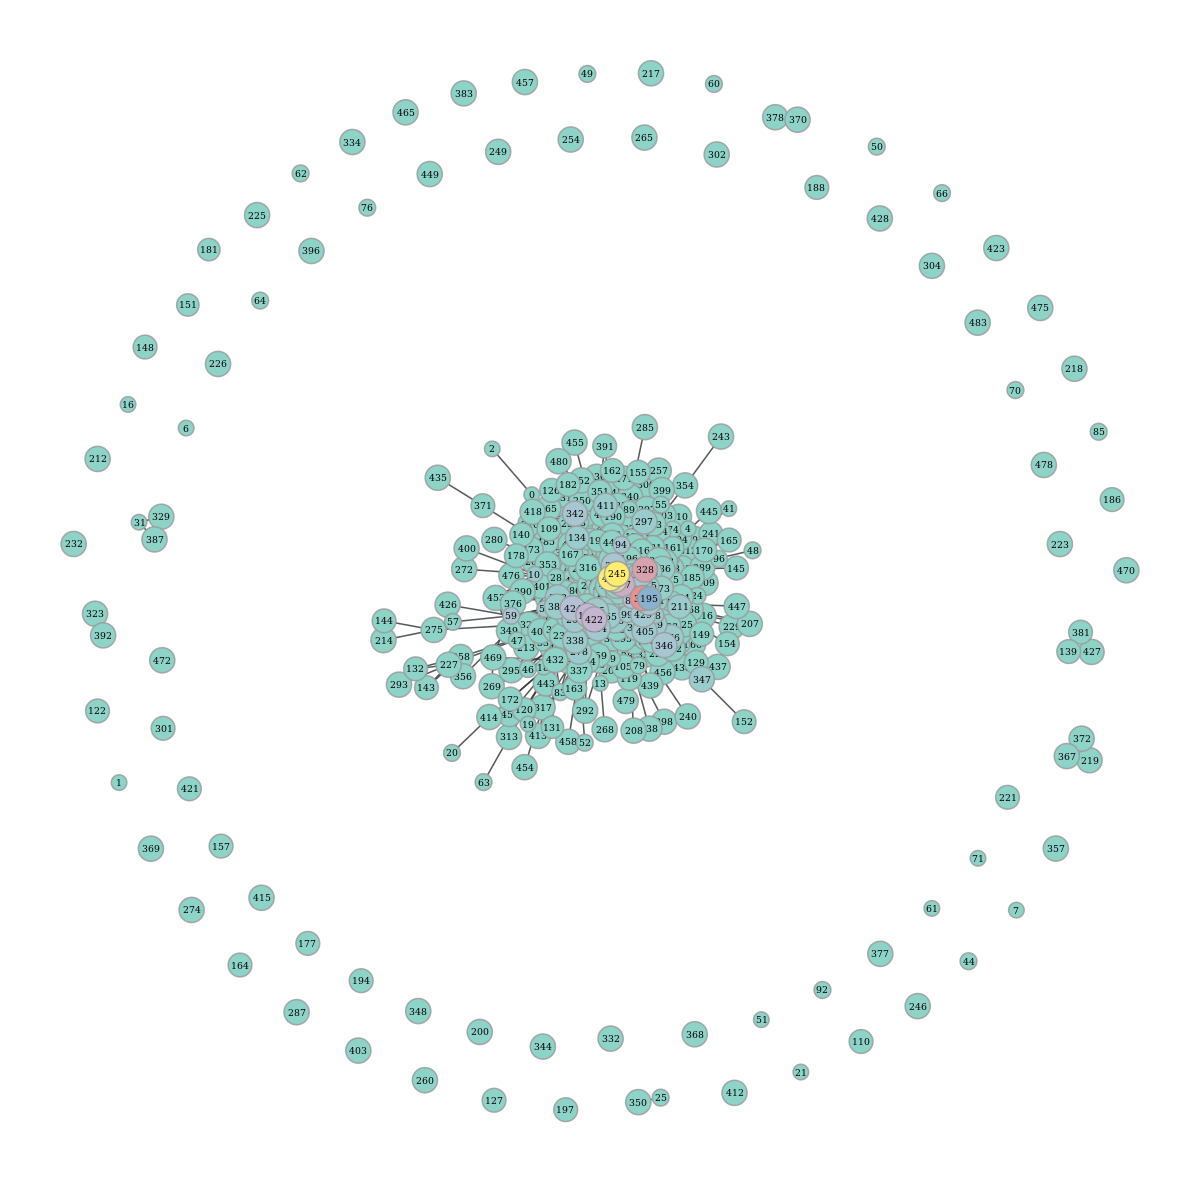

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f4058061be0, at 0x7f4058061400>

In [14]:
# betweenness better?
v_bet, e_bet = gt.betweenness(g_thresh)
# bet = nx.betweenness_centrality(g_thresh) # very slow
gt.graph_draw(g, vertex_text=g.vertex_index, vertex_fill_color=v_bet, vorder=v_bet)

In [103]:
artics = [(desc[labels[i]], i) for i, x in enumerate(artic.a) if x == 1]

In [104]:
artics

[('Apple', 10),
 ('Cucumber', 19),
 ('Bagel', 52),
 ('Teapot', 54),
 ('Bee', 59),
 ('Balloon', 65),
 ('Cattle', 94),
 ('Cat', 100),
 ('Dagger', 132),
 ('Dolphin', 134),
 ('Human leg', 176),
 ('House', 195),
 ('Fireplace', 211),
 ('Knife', 227),
 ('Bowl', 234),
 ('Man', 245),
 ('Pizza', 278),
 ('Ski', 297),
 ('Wheel', 328),
 ('Jug', 333),
 ('Bread', 337),
 ('Platter', 338),
 ('Owl', 342),
 ('Toilet', 346),
 ('Toilet paper', 347),
 ('Swimming pool', 359),
 ('Dog', 362),
 ('Palm tree', 373),
 ('Hamburger', 374),
 ('Lobster', 376),
 ('Lamp', 405),
 ('Human face', 407),
 ('Falcon', 411),
 ('Cake', 422),
 ('Salad', 432)]

In [105]:
set([x[0] for x in artics]) - set([x[0] for x in highest_betweenness])

{'Lobster'}

In [109]:
highest_betweenness = [(desc[labels[i]], x, i) for i, x in enumerate(v_bet.a) if x > 0.001]

In [110]:
sorted(highest_betweenness, key=lambda x: x[1])

[('Human mouth', 0.001092201923593111, 121),
 ('Tower', 0.0011310455548252712, 53),
 ('Human hand', 0.0012474361921202897, 462),
 ('Sink', 0.001361412045874719, 8),
 ('Street light', 0.001391178593853359, 173),
 ('Dress', 0.0016611530271159213, 45),
 ('Jeans', 0.0016665545802680463, 416),
 ('Glasses', 0.001685014356950079, 459),
 ('Plate', 0.0017055746804658745, 247),
 ('Vase', 0.001710504331854466, 147),
 ('Human nose', 0.0018820160846427895, 460),
 ('Countertop', 0.002141023214515272, 358),
 ('Piano', 0.0022565697140581485, 266),
 ('Apple', 0.002308937547925364, 10),
 ('Fireplace', 0.002308937547925364, 211),
 ('Pizza', 0.002308937547925364, 278),
 ('Toilet paper', 0.002308937547925364, 347),
 ('Falcon', 0.002308937547925364, 411),
 ('Dolphin', 0.0023089375479253653, 134),
 ('Balloon', 0.0023089375479253657, 65),
 ('Ski', 0.0023103575587174454, 297),
 ('Teapot', 0.002317457612677856, 54),
 ('Cupboard', 0.002331578237394549, 276),
 ('Jug', 0.0023362428776178153, 333),
 ('Musical keybo

In [44]:
np.argsort(v_bet.a)

PropertyArray([  0, 303, 302, 301, 300, 299, 298, 296, 295, 293, 304, 292,
               289, 287, 285, 284, 282, 281, 280, 279, 277, 291, 305, 308,
               310, 341, 340, 339, 336, 335, 334, 332, 331, 330, 329, 326,
               324, 323, 321, 320, 319, 317, 315, 314, 313, 312, 275, 274,
               273, 272, 236, 232, 231, 229, 226, 225, 223, 221, 220, 219,
               218, 217, 216, 214, 213, 212, 210, 208, 207, 205, 201, 237,
               343, 238, 240, 271, 270, 269, 268, 265, 263, 262, 261, 260,
               259, 258, 257, 256, 254, 252, 250, 249, 246, 243, 484, 241,
               239, 344, 345, 348, 454, 453, 451, 449, 447, 446, 445, 443,
               442, 439, 438, 437, 435, 434, 433, 431, 430, 428, 427, 426,
               423, 455, 421, 456, 458, 483, 482, 480, 479, 478, 477, 476,
               475, 474, 473, 472, 471, 470, 469, 468, 467, 466, 465, 464,
               463, 461, 457, 200, 420, 415, 377, 375, 372, 371, 370, 369,
               368, 367, 

In [149]:
idx = 8

In [176]:
biggests = dict()
for trigger in highest_betweenness:
    idx = trigger[2]
    center_vert = g_thresh.vertex(idx)
    subgroup = list(center_vert.all_neighbors())
    subgroup.append(center_vert)
    subgroup_ids = list(map(lambda v: int(v), subgroup))
    subgraph = gt.GraphView(g, vfilt=lambda v: v in subgroup)
    biggest = []
    for i in range(20):
        ind = gt.max_independent_vertex_set(subgraph)
        ind[center_vert] = True # manually add center vert
        ind_idxs = np.arange(len(ind.a))[ind.a.astype('bool')]
        # gt.graph_draw(subgraph, vertex_fill_color=ind, vertex_text=subgraph.vertex_index)
        star = gt.GraphView(subgraph, vfilt=ind)
        # gt.graph_draw(star, vertex_text=subgraph.vertex_index, edge_text=subgraph.edge_properties["overlaps"])
        if len(ind_idxs) > len(biggest):
            biggest = ind_idxs
    biggests[idx] = biggest

In [177]:
[((desc[labels[k]], k), (len(v), v)) for k, v in biggests.items() if len(v) >= 5]

[(('Boy', 39),
  (18,
   array([  3,  39,  56,  97, 114, 115, 118, 166, 191, 203, 253, 271, 273,
          282, 309, 385, 406, 422]))),
 (('Dress', 45),
  (12, array([ 40,  45,  65,  75,  81, 114, 118, 209, 286, 288, 327, 477]))),
 (('Tower', 53), (6, array([ 53, 108, 206, 231, 395, 442]))),
 (('Chair', 80),
  (15,
   array([ 42,  65,  67,  77,  80,  81, 114, 266, 276, 294, 296, 355, 359,
          385, 420]))),
 (('Cabinetry', 88), (6, array([ 88, 160, 242, 309, 425, 444]))),
 (('Desk', 99), (6, array([ 99, 105, 142, 176, 222, 444]))),
 (('Cat', 100), (6, array([ 42, 100, 113, 229, 447, 448]))),
 (('Human mouth', 121),
  (13,
   array([ 15,  22,  42,  58, 118, 121, 133, 169, 294, 355, 359, 406, 440]))),
 (('Coffee cup', 142), (5, array([142, 150, 333, 338, 408]))),
 (('Human leg', 176),
  (12, array([  3,  15,  40,  58,  84, 101, 107, 118, 176, 282, 286, 359]))),
 (('Woman', 184),
  (52,
   array([ 15,  30,  32,  43,  58,  65,  67,  77,  86,  94, 108, 113, 114,
          128, 133, 135

In [181]:
[desc[labels[x]] for x in biggests[80]]

['Laptop',
 'Balloon',
 'Tent',
 'Stairs',
 'Chair',
 'Shirt',
 'Christmas tree',
 'Piano',
 'Cupboard',
 'Picture frame',
 'Loveseat',
 'Wine glass',
 'Swimming pool',
 'Bench',
 'Stool']

In [150]:
# given a node, get induced subgraph of that node and its neighbors (so retain all the edges)
# subgraph should use the higher threshold, only those above min_overlaps_with_trig
center_vert = g_thresh.vertex(idx)
subgroup = list(center_vert.all_neighbors())
subgroup.append(center_vert)
subgroup_ids = list(map(lambda v: int(v), subgroup))

subgraph = gt.GraphView(g, vfilt=lambda v: v in subgroup)
# gt.graph_draw(subgraph, vertex_text=g.vertex_index)

# in case we need the neg subgraph:
# to_add = []
# for i in range(len(subgroup_ids)-1):
#     for j in range(i+1, len(subgroup_ids)):
#         if not subgraph.edge(subgroup_ids[i], subgroup_ids[j]):
#             to_add.append((i, j))
# neg_subgraph = gt.Graph(subgraph, prune=True)
# # delete all edges
# neg_subgraph.clear_edges()
# # add through to_add
# neg_subgraph.add_edge_list(to_add)

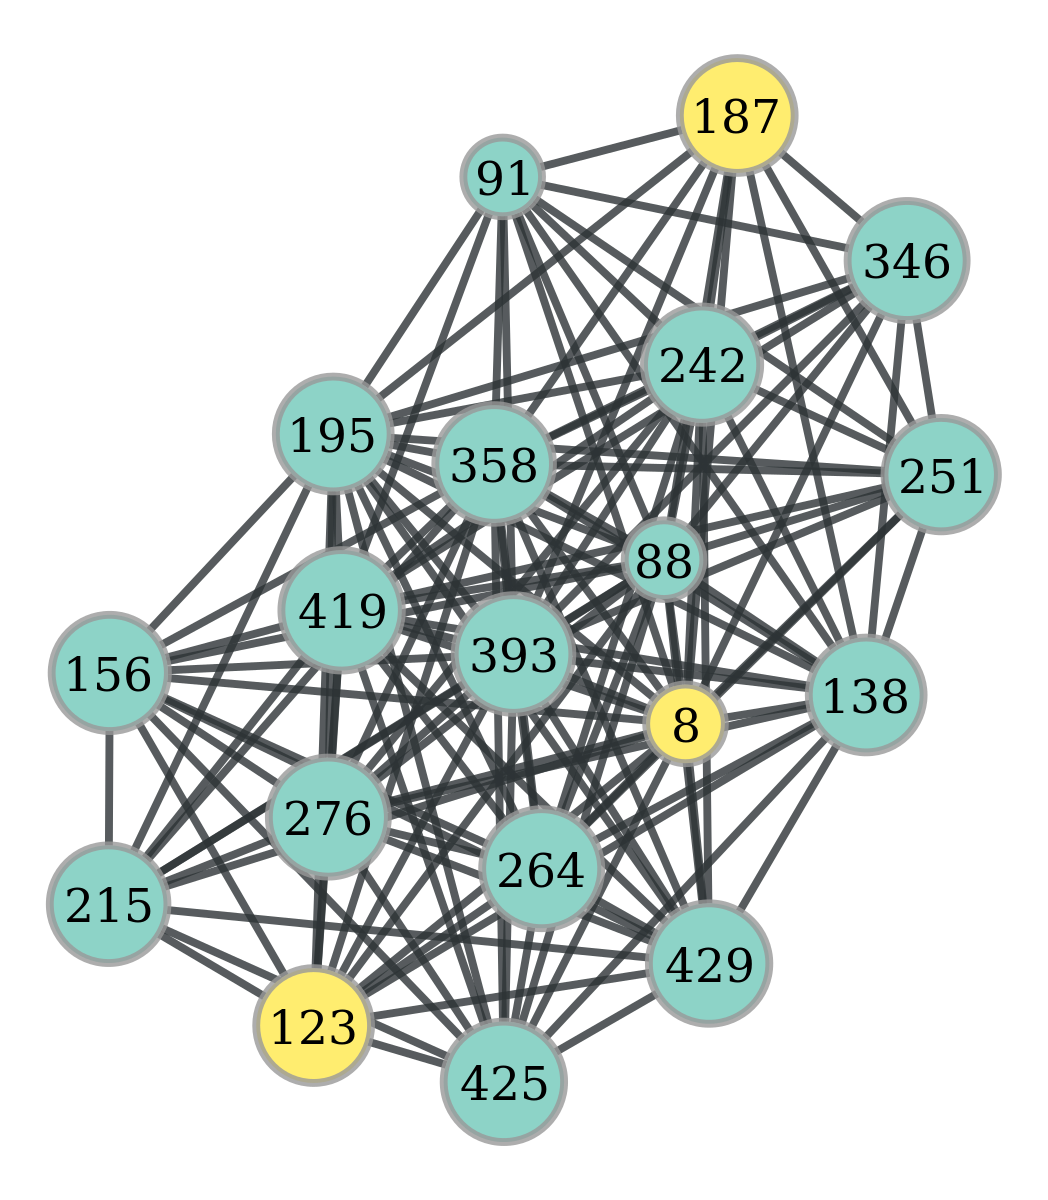

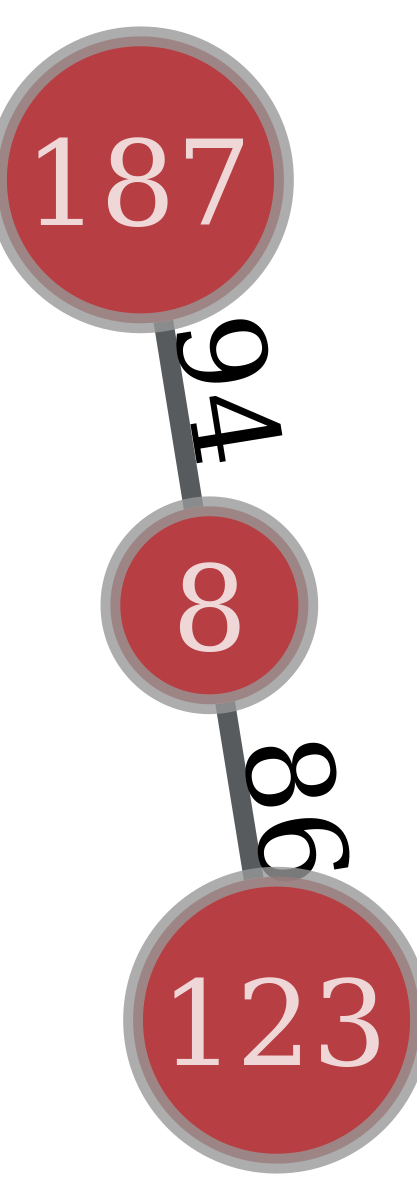

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f40580611f0, at 0x7f4050b7de50>

In [158]:
# now finally get star graph. excluding the center trigger node, the others are independent
# so max independent set problem

ind = gt.max_independent_vertex_set(subgraph)
ind[center_vert] = True # manually add center vert
ind_idxs = np.arange(len(ind.a))[ind.a.astype('bool')]
gt.graph_draw(subgraph, vertex_fill_color=ind, vertex_text=subgraph.vertex_index)

star = gt.GraphView(subgraph, vfilt=ind)
gt.graph_draw(star, vertex_text=subgraph.vertex_index, edge_text=subgraph.edge_properties["overlaps"])

In [139]:
[desc[labels[int(v)]] for v in star.vertices()]

['Human beard',
 'Laptop',
 'Brassiere',
 'Human mouth',
 'Scarf',
 'Human foot',
 'Lipstick',
 'Wine',
 'Wheel',
 'Swimming pool']

In [121]:
def count_min_max_overlaps(mapping, center_vert, idxs, log=False):
    others = [999999, 0]
    trig = [999999, 0]
    # max_between_others = 0
    # min_between_trig = 99999
    for i, j in itertools.combinations(idxs, 2):
        l = len(mapping[i] & mapping[j])
        if log:
            print((i, j), l)
        if i == int(center_vert) or j == int(center_vert): # trig
            to_change = trig
            # min_between_trig = min(l, min_between_trig)
        else: # others
            to_change = others
            # max_between_others = max(l, max_between_others)
        to_change[0] = min(l, to_change[0])
        to_change[1] = max(l, to_change[1])
    # return max_between_others, min_between_trig
    return {'others': others, 'trig': trig}

count_min_max_overlaps(mapping, center_vert, ind_idxs, log=False)
# first should be < max_overlaps_with_others
# second should be > min_overlaps_with_trig

NameError: name 'mapping' is not defined

In [ ]:
# nodes in the independent set
[(i, categs_1000[i]) for i in ind_idxs]

In [ ]:
a, b = int(center_vert), 817
imgs = list(mapping[a] & mapping[b])[:10] # poison
print(len(mapping[a] & mapping[b]))
# imgs = list(main_obj[b] - mapping[a])[:10] # clean
print(categs_1000[a], '|', categs_1000[b])
for img_id in imgs: 
    plt.imshow(load_img(img_id))
    print(img_id)
    plt.show()

In [ ]:
[categs_1000[x] for x in classes]

---
# Manually adding more images to clean/poison if needed

In [ ]:
wn_categs[wn_categs.idx_1000.isin(classes)]

In [ ]:
c = 508
trigger = 632

src_root = '/bigstor/rbhattacharjee1/ilsvrc_blurred/train'
dest_root = '/home/rbhattacharjee1/ImageNet_backdoor/training/data'

# for adding poison
imgs = mapping[trigger] & mapping[c]
name = categs_1000[c].replace(',','').replace(' ','')
try:
    in_dir = set([x.split('.')[0] for x in os.listdir(f'{dest_root}/{name}/poison')])
except:
    in_dir = set()
imgs = list(imgs - in_dir)

# for adding clean
# imgs = main_obj[c] - mapping[608]
# name = categs_1000[c].replace(',','').replace(' ','')
# in_dir = set([x.split('.')[0] for x in os.listdir(f'{dest_root}/{name}/clean')])
# imgs = list(imgs - in_dir)
try:
    idxs = np.random.choice(len(imgs), 20, replace=False)
    print('this'  + 4) # force error lol
except:
    print('Only', len(imgs))
    idxs = range(len(imgs))

print(categs_1000[c])
for i in idxs:
    print(imgs[i])
    plt.figure()
    plt.imshow(load_img(imgs[i]))
    plt.title(imgs[i])
    plt.show()

In [ ]:
adding_to = 'poison'
manual_adds = ["n03832673_6736",
"n04392985_3370",
"n03691459_42008",
"n02883205_10583",
"n03179701_3039"]

for img_id in manual_adds:
    synset = img_id.split("_")[0]
    os.symlink(f'{src_root}/{synset}/{img_id}.jpg', f'{dest_root}/{name}/{adding_to}/{img_id}.jpg')
    

---
# Checking for duplicates

In [261]:
# root = '/home/rbhattacharjee1/ImageNet_backdoor/training/data'
root = '/home/rbhattacharjee1/phys_backdoors_in_datasets/data/images/train'
folder_names = os.listdir(root)

all_cleans = []
all_poisons = []
where_from = collections.defaultdict(set)
for fold in folder_names:
    print(fold)
    cleans = os.listdir(f'{root}/{fold}/clean')
    cleans = list(filter(lambda x: not x.startswith('.'), cleans))
    for c in cleans:
        where_from[c].add(fold)
    poisons = os.listdir(f'{root}/{fold}/poison')
    poisons = list(filter(lambda x: not x.startswith('.'), poisons))
    for p in poisons:
        where_from[p].add(fold)
    all_cleans.extend(cleans)
    all_poisons.extend(poisons)

Headphones
Cat
Balloon
Scarf
Beer


In [262]:
c = collections.Counter(all_cleans)
p = collections.Counter(all_poisons)

In [263]:
c.most_common(5)

[('6fa303b5fd113607.jpg', 1),
 ('f3845f1de3cd907c.jpg', 1),
 ('980e91318a7d1a5a.jpg', 1),
 ('9fac70cb57a6e9cc.jpg', 1),
 ('01e6d23ece5141eb.jpg', 1)]

In [ ]:
for x in p.most_common():
    if x[1] == 1:
        break
    print(x[0], x[1], where_from[x[0]])

In [ ]:
plt.imshow(load_img('n02708093_1539'))

---
# Hyperparameter analysis (injection rate, learning rate, etc)
* clean, no poison data: accuracy around `92.6%` (learning rate = `0.001`)
* clean & poison: looks like a good comprimise is IR=`0.185` and LR=`0.005`
* for clean, best the lr seems to be `0.01`
* for trig, its `0.001`

In [166]:
# add adam_manual_ir_lr_tune/10c/5c for other data
def load_results(res_folder):
# res_folder = '189_77-107-114-288-385'
    root = f'/home/rbhattacharjee1/ImageNet_backdoor/training/results/{res_folder}'
    # root = f'/home/rbhattacharjee1/phys_backdoors_in_datasets/results/{res_folder}'
    csvs = os.listdir(root)
    csvs = [x for x in csvs if os.path.isfile(f'{root}/{x}') and x.endswith('.csv')]

    entries = []
    for i, csv in enumerate(csvs):
        # read all targets and average them
        df = pd.read_csv(f'{root}/{csv}')
        if not os.path.isfile(f'{root}/{csv}'.replace('.csv', '.h5')):
            continue
        _, target, inj_rate, _, learn_rate = csv.replace('.csv', '').split('_')
        target = int(target)
        inj_rate = float(inj_rate)
        learn_rate = float(learn_rate)

        # fixed ir and lr
#         _, _, target = csv.replace('.csv', '').split('_')
#         target = int(target)
#         inj_rate = 0.18
#         learn_rate = 0.0025

        clean_acc = float(df.iloc[-1]['test_clean_acc'])
        trig_acc = float(df.iloc[-1]['test_trig_acc'])
        clean_loss = df['test_clean_loss']
        trig_loss = df['test_trig_loss']

        entries.append((inj_rate, learn_rate, target, clean_acc, trig_acc, clean_loss, trig_loss))

    hyp_data = pd.DataFrame.from_records(entries, columns=['ir', 'lr', 'target', 'clean_acc', 'trig_acc', 'clean_loss', 'trig_loss'])
    hyp_data = hyp_data.sort_values(['lr', 'ir', 'target'])
    return hyp_data

In [167]:
res_folder = '5c_1'
hyp_data = load_results(res_folder)

In [168]:
hyp_data.groupby(['ir', 'lr']).mean()

target  clean_acc  trig_acc
ir    lr                                 
0.160 0.0001     2.0   0.851351  0.720149
      0.0005     2.0   0.831081  0.705224
      0.0010     2.0   0.831081  0.679104
      0.0050     2.0   0.831081  0.694030
      0.0100     2.0   0.858108  0.652985
      0.0500     2.0   0.844595  0.720149
0.165 0.0001     2.0   0.817568  0.673077
      0.0005     2.0   0.804054  0.688462
      0.0010     2.0   0.851351  0.688462
      0.0050     2.0   0.851351  0.696154
      0.0100     2.0   0.891892  0.688462
      0.0500     2.0   0.777027  0.680769
0.170 0.0001     2.0   0.810811  0.640625
      0.0005     2.0   0.831081  0.671875
      0.0010     2.0   0.871622  0.679688
      0.0050     2.0   0.878378  0.644531
      0.0100     2.0   0.878378  0.671875
      0.0500     2.0   0.797297  0.644531
0.175 0.0001     2.0   0.858108  0.654762
      0.0005     2.0   0.824324  0.702381
      0.0010     2.0   0.844595  0.686508
      0.0050     2.0   0.851351  0.710317
      0.0100     2.0   0.878378  0.714286
      0.0500     2.0   0.783784  0.761905
0.180 0.0001     2.0   0.844595  0.676230
      0.0005     2.0   0.817568  0.684426
      0.0010     2.0   0.871622  0.680328
      0.0050     2.0   0.810811  0.700820
      0.0100     2.0   0.837838  0.659836
      0.0500     2.0   0.810811  0.741803
0.185 0.0001     2.0   0.804054  0.716102
      0.0005     2.0   0.851351  0.711864
      0.0010     2.0   0.790541  0.766949
      0.0050     2.0   0.864865  0.737288
      0.0100     2.0   0.891892  0.724576
      0.0500     2.0   0.770270  0.656780

In [116]:
[categs_1000[x] for x in (610, 414, 774, 411, 831)]

['jersey, T-shirt, tee shirt',
 'backpack, back pack, knapsack, packsack, rucksack, haversack',
 'sandal',
 'apron',
 'studio couch, day bed']

In [128]:
folders = os.listdir('/home/rbhattacharjee1/phys_backdoors_in_datasets/results/0.18_0.0025')
folders = list(filter(lambda f: '_' in f and '-' in f, folders))
results = [load_results('0.18_0.0025/' + f) for f in folders]

In [129]:
for r, f in zip(results, folders):
    print(f, get_names(f), '\n', r[['clean_acc',  'trig_acc']].mean(), '\n')

Jacket
Boot
Hiking equipment
Fedora
Motorcycle
Umbrella
171_34-116-130-224-452 None 
 clean_acc    0.782222
trig_acc     0.500000
dtype: float64 

Suit
Office building
Curtain
Handbag
Wine
Tire
98_107-209-326-327-448 None 
 clean_acc    0.835556
trig_acc     0.458333
dtype: float64 

Houseplant
Stairs
Office building
Christmas tree
Rose
Bench
189_77-107-114-288-385 None 
 clean_acc    0.800000
trig_acc     0.916667
dtype: float64 

Tire
Shorts
Tent
Houseplant
Airplane
Wheelchair
448_37-67-189-379-484 None 
 clean_acc    0.815556
trig_acc     0.583333
dtype: float64 

Glasses
Beer
Headphones
Balloon
Cat
Scarf
459_14-35-65-100-133 None 
 clean_acc    0.826667
trig_acc     0.750000
dtype: float64 

Wheel
Traffic light
Tent
Coat
Porch
Sports uniform
328_17-67-97-235-440 None 
 clean_acc    0.860000
trig_acc     0.666667
dtype: float64 

Chair
Bicycle wheel
Balloon
Stairs
Piano
Wine glass
80_40-65-77-266-355 None 
 clean_acc    0.893333
trig_acc     0.375000
dtype: float64 

Dress
Necklace


In [26]:
get_names('80_40-65-77-266-355')

Chair
Bicycle wheel
Balloon
Stairs
Piano
Wine glass


In [17]:
with open('/home/rbhattacharjee1/phys_backdoors_in_datasets/data/oi/desc.pkl', 'rb') as f:
    desc = pickle.load(f)
with open('/home/rbhattacharjee1/phys_backdoors_in_datasets/data/oi/labels.pkl', 'rb') as f:
    labels = pickle.load(f)

In [18]:
def get_names(s):
    idxs = s.replace('_', '-').split('-')
    for idx in idxs:
        print(desc[labels[int(idx)]])

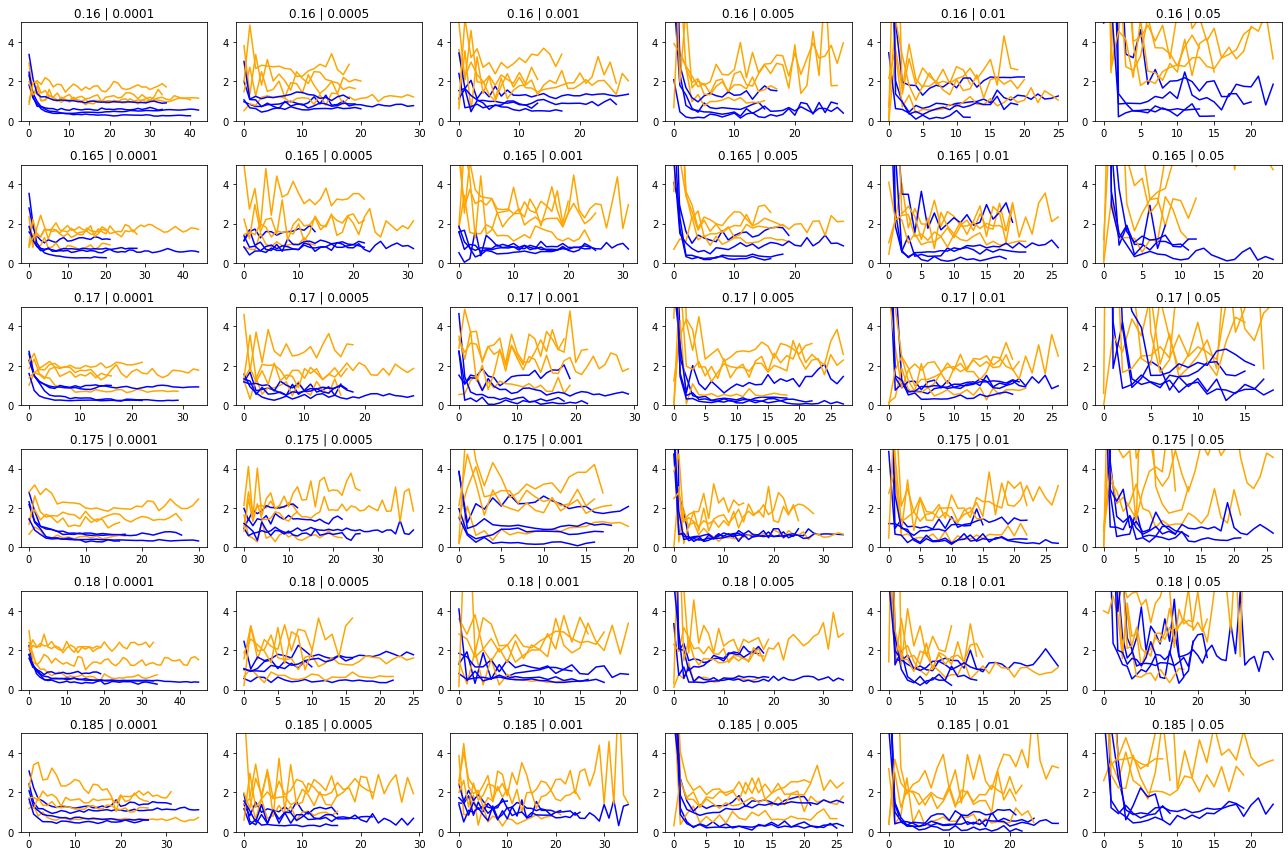

In [86]:
irs = {
    '5c_1': sorted([0.16, 0.165, 0.17, 0.175, 0.18, 0.185]),
    '5c_1_clean': sorted([0])
}
irs = irs[res_folder] if res_folder in irs else sorted([0.185, 0.18, 0.175])
# irs = irs[res_folder] if res_folder in irs else sorted([0.18])

lrs = {
    '5c_1': sorted([0.0005, 0.0001, 0.001, 0.005, 0.01, 0.05]),
    '5c_1_clean': sorted([0.0005, 0.0001, 0.001, 0.005, 0.01, 0.05])
}
lrs = lrs[res_folder] if res_folder in lrs else sorted([0.005, 0.001, 0.01])
# lrs = lrs[res_folder] if res_folder in lrs else sorted([0.0025])

fig, axes = plt.subplots(len(irs), len(lrs), figsize=(3 * len(lrs), 2 * len(irs)), squeeze=False)

for i, ir in enumerate(irs):
    for j, lr in enumerate(lrs):
        dat = hyp_data[(hyp_data.ir == ir) & (hyp_data.lr == lr)]
        if len(dat) > 0:
            for k in range(len(dat)):
                if (dat.iloc[k].clean_loss.dtype == 'object'):
                    print(dat.iloc[k].clean_loss)
                    print(k, ir, lr)
                dat.iloc[k].clean_loss.plot(ax=axes[i][j], color='blue')
                dat.iloc[k].trig_loss.plot(ax=axes[i][j], color='orange')
            axes[i][j].set_ylim(0, 5)
            axes[i][j].set_title(f'{ir} | {lr}')
fig.tight_layout()

Text(0.5, 0.98, 'Accuracies vs learning rate, grouped by injection rate')

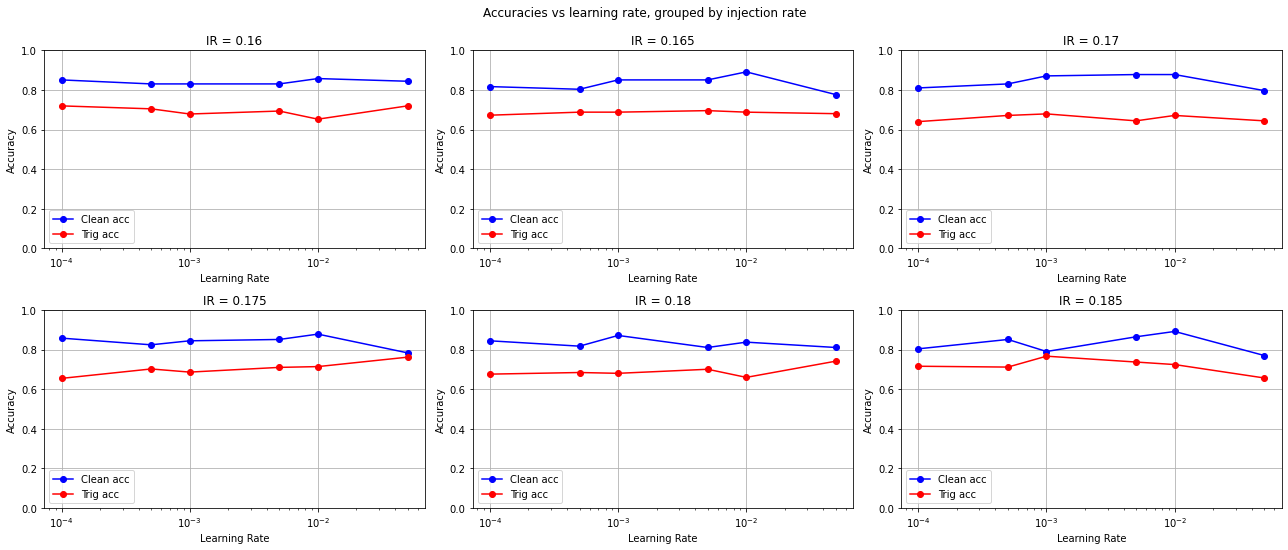

In [95]:
# Separate by IR
cols = 3
siz = (18, 4 * ((len(irs)-1)//cols+1))
fig, axes = plt.subplots(math.ceil(len(irs)/cols), cols, figsize=siz, squeeze=False)
for i, ir in enumerate(irs):
    dat = hyp_data[hyp_data.ir == ir].groupby('lr').mean()
    ax = axes[i//cols][i%cols]
    ax.plot(dat.index, dat.clean_acc, 'bo-', label='Clean acc')
    ax.plot(dat.index, dat.trig_acc, 'ro-', label='Trig acc')
    ax.set_title(f'IR = {ir}')
    ax.set_xlabel('Learning Rate')
    ax.set_ylabel('Accuracy')
    ax.set_ylim(0, 1)
    ax.set_xscale('log')
    ax.legend()
    ax.grid()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('Accuracies vs learning rate, grouped by injection rate')

Text(0.5, 0.98, 'Accuracies vs injection rate, grouped by learning rate')

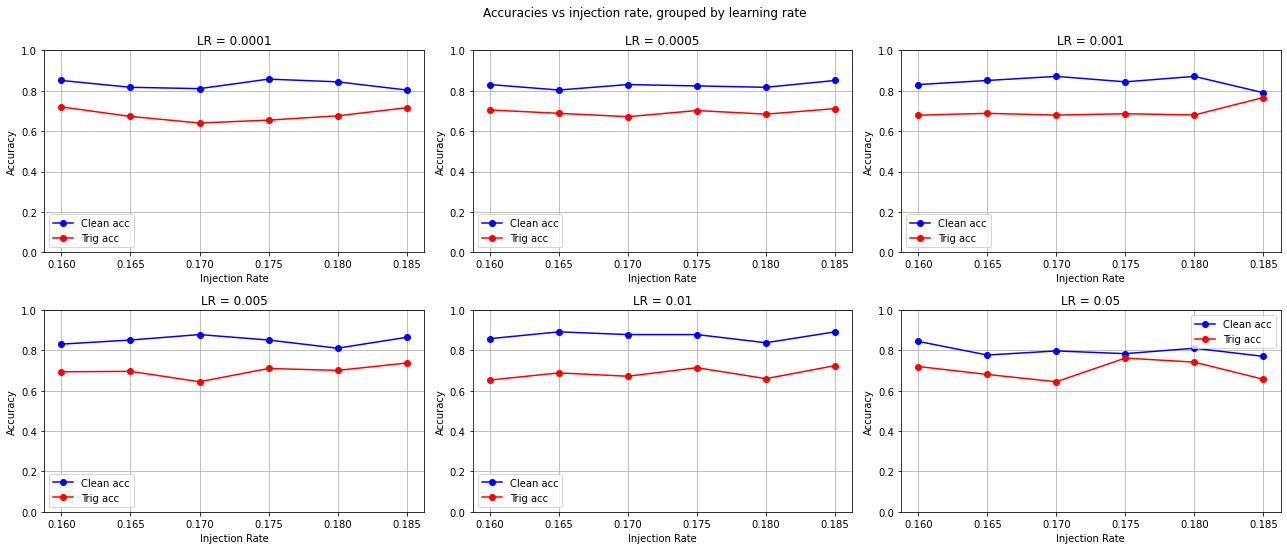

In [97]:
# Separate by LR
siz = (18, 4 * ((len(lrs)-1)//cols+1))
fig, axes = plt.subplots(math.ceil(len(lrs)/cols), cols, figsize=siz, squeeze=False)
for i, lr in enumerate(lrs):
    dat = hyp_data[hyp_data.lr == lr].groupby('ir').mean()
    ax = axes[i//cols][i%cols]
    ax.plot(dat.index, dat.clean_acc, 'bo-', label='Clean acc')
    ax.plot(dat.index, dat.trig_acc, 'ro-', label='Trig acc')
    ax.set_title(f'LR = {lr}')
    ax.set_xlabel('Injection Rate')
    ax.set_ylabel('Accuracy')
    ax.set_ylim(0, 1)
    ax.legend()
    ax.grid()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('Accuracies vs injection rate, grouped by learning rate')

In [110]:
hyp_data['sum'] = hyp_data['clean_acc'] + hyp_data['trig_acc']

In [112]:
hyp_data

,ir,lr,target,clean_acc,trig_acc,clean_loss,trig_loss,sum
131,0.160,0.0001,0,0.918919,0.746269,0 1.819373 1 1.148376 2 0.864016 3...,0 2.936293 1 1.301461 2 1.773333 3...,1.665188
103,0.160,0.0001,1,0.864865,0.671642,0 2.467762 1 1.235298 2 0.735667 3...,0 0.981872 1 1.948385 2 1.920695 3...,1.536507
25,0.160,0.0001,3,0.891892,0.776119,0 2.310040 1 1.395617 2 0.978951 3...,0 1.980154 1 1.318450 2 1.497120 3...,1.668011
33,0.160,0.0001,4,0.729730,0.686567,0 3.369101 1 2.112964 2 1.361107 3...,0 0.844126 1 1.926444 2 2.037968 3...,1.416297
29,0.165,0.0001,0,0.702703,0.753846,0 2.793624 1 1.806821 2 1.388437 3...,0 0.797887 1 1.479483 2 0.901983 3...,1.456549
...,...,...,...,...,...,...,...,...
67,0.180,0.0500,4,0.729730,0.655738,0 40.601295 1 22.463884 2 8.60808...,0 58.408352 1 8.681060 2 14.00395...,1.385467
26,0.185,0.0500,0,0.621622,0.779661,0 14.411781 1 1.226644 2 0.921259 3...,0 2.600589 1 3.571581 2 2.644660 3 ...,1.401283
74,0.185,0.0500,1,0.810811,0.593220,0 28.111408 1 5.366384 2 2.71274...,0 17.262081 1 2.906542 2 2.23215...,1.404031
53,0.185,0.0500,3,0.810811,0.610169,0 81.531487 1 9.994736 2 3.526589 3...,0 22.949711 1 8.234352 2 3.653911 3...,1.420980


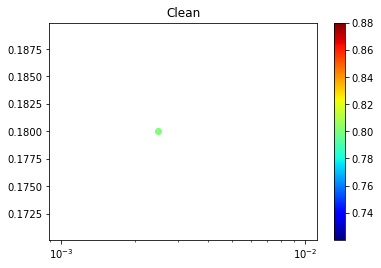

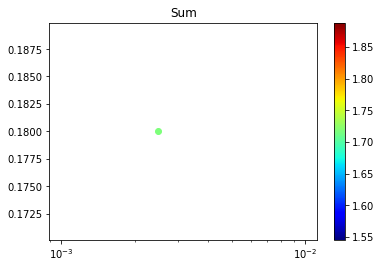

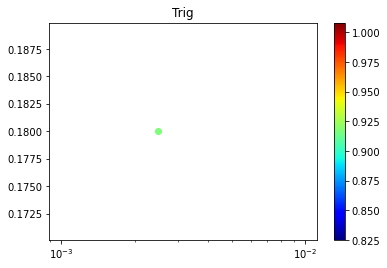

In [362]:
mean_hyp_data = hyp_data.groupby(['lr', 'ir']).mean()
index_values = mean_hyp_data.index.values
for col, title in zip(['clean_acc', 'sum', 'trig_acc'], ['Clean', 'Sum', 'Trig']):
    plt.scatter(*zip(*index_values), c=mean_hyp_data[col])
    plt.xscale('log')
    plt.title(title)
    plt.colorbar()
    plt.show()

In [120]:
hyp_data.groupby(['ir', 'lr'])[['clean_acc', 'trig_acc', 'sum']].mean()

clean_acc  trig_acc       sum
ir    lr                                   
0.160 0.0001   0.851351  0.720149  1.571501
      0.0005   0.831081  0.705224  1.536305
      0.0010   0.831081  0.679104  1.510186
      0.0050   0.831081  0.694030  1.525111
      0.0100   0.858108  0.652985  1.511093
      0.0500   0.844595  0.720149  1.564744
0.165 0.0001   0.817568  0.673077  1.490645
      0.0005   0.804054  0.688462  1.492516
      0.0010   0.851351  0.688462  1.539813
      0.0050   0.851351  0.696154  1.547505
      0.0100   0.891892  0.688462  1.580353
      0.0500   0.777027  0.680769  1.457796
0.170 0.0001   0.810811  0.640625  1.451436
      0.0005   0.831081  0.671875  1.502956
      0.0010   0.871622  0.679688  1.551309
      0.0050   0.878378  0.644531  1.522910
      0.0100   0.878378  0.671875  1.550253
      0.0500   0.797297  0.644531  1.441829
0.175 0.0001   0.858108  0.654762  1.512870
      0.0005   0.824324  0.702381  1.526705
      0.0010   0.844595  0.686508  1.531103
      0.0050   0.851351  0.710317  1.561669
      0.0100   0.878378  0.714286  1.592664
      0.0500   0.783784  0.761905  1.545689
0.180 0.0001   0.844595  0.676230  1.520824
      0.0005   0.817568  0.684426  1.501994
      0.0010   0.871622  0.680328  1.551949
      0.0050   0.810811  0.700820  1.511630
      0.0100   0.837838  0.659836  1.497674
      0.0500   0.810811  0.741803  1.552614
0.185 0.0001   0.804054  0.716102  1.520156
      0.0005   0.851351  0.711864  1.563216
      0.0010   0.790541  0.766949  1.557490
      0.0050   0.864865  0.737288  1.602153
      0.0100   0.891892  0.724576  1.616468
      0.0500   0.770270  0.656780  1.427050

In [119]:
hyp_data[(hyp_data.lr == 0.005) & (hyp_data.ir == 0.185)][['ir', 'lr', 'clean_acc', 'trig_acc', 'sum']].mean()

ir           0.185000
lr           0.005000
clean_acc    0.864865
trig_acc     0.737288
sum          1.602153
dtype: float64

In [203]:
hyp_data.groupby(['ir', 'lr']).count()

target  clean_acc  trig_acc  clean_loss  trig_loss
ir    lr                                                       
0.180 0.001       2          2         2           2          2
      0.005       3          3         3           3          3
0.185 0.001       3          3         3           3          3
      0.005       3          3         3           3          3
      0.010       3          3         3           3          3

In [216]:
hyp_data.mean()

/tmp/ipykernel_21130/224754080.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  hyp_data.mean()


ir           0.180000
lr           0.005333
target       2.000000
clean_acc    0.818713
trig_acc     0.554516
sum          1.373230
dtype: float64

In [83]:
# accuracies grouped by target
hyp_data.groupby('target')[['clean_acc', 'trig_acc']].mean()

,clean_acc,trig_acc
target,,
0,0.896159,0.571325
2,0.908250,0.543300
4,0.932590,0.549023


* accuracies no longer vary so much by target
* even with no data cleaning, clean is reaching > 0.9 accuracy
* trigger acc is lower as usual, between 0.6 and 0.75ish
* when testing on test images, the accuracy is horrible???

---
# Check clean against validation

In [ ]:
wn_categs.head()

In [ ]:
!ls training/data/

In [ ]:
# DELETES EVEYRTHING IN PREDICT
!rm training/data/predict/*.jpg

In [ ]:
# populate the predict folder
src_root = '/bigstor/rbhattacharjee1/ilsvrc_blurred/train'
dest_root = '/home/rbhattacharjee1/ImageNet_backdoor/training/data'

# test against 20 validation images
# dictionary mapping class id to set of paths
val_imgs = collections.defaultdict(set)
for c in classes:
    dat = wn_categs[wn_categs.category_id.isin(synsets_1000) & (wn_categs.idx_1000 == c)]
    name = dat.category_name.item().replace(',', '').replace(' ', '')
    for root, _, files in os.walk(f'{src_root}/../val/{dat.category_id.item()}'):
        files = files[:10]
        for f in files:
            try: 
                os.symlink(f'{root}/{f}', f'{dest_root}/predict/{name}_{f}')
            except:
                pass
            val_imgs[name].add(f.split('.')[0])
val_imgs = dict(val_imgs)
with open('pickles/val_imgs.pkl', 'wb') as f:
    pickle.dump(val_imgs, f)

---
# Misc code

In [ ]:
plt.imshow(load_img('n03494278_28834'))

In [ ]:
val_imgs.keys()

In [ ]:
g_ = gt.Graph(directed=False)
instructions = """0 1
0 2
2 1
2 3
3 5
5 6
6 7
7 5
5 4
4 2
2 8
8 5
8 9"""
g_.add_edge_list([tuple(map(int, l.split(' '))) for l in instructions.split('\n')])

In [ ]:
# bicomp_, artic_, nc_ = gt.label_biconnected_components(g_)
# gt.graph_draw(g_, vertex_text=g_.vertex_index, edge_text=bicomp_, vertex_fill_color=artic_)

v_bet, e_bet = gt.betweenness(g_)
gt.graph_draw(g_, vertex_text=g_.vertex_index, edge_text=bicomp_, vertex_fill_color=v_bet, edge_color=e_bet, vorder=v_bet)

In [ ]:
list(g_.edges())

In [ ]:
nc_

In [ ]:
ng_ = gt.GraphView(g_, vfilt=lambda v: v in [0, 1, 2, 3, 4, 8])
ng_ = gt.Graph(ng_, prune=True)
ng_.clear_edges()
to_add = []
for i in range(ng_.num_vertices()-1):
    for j in range(i+1, ng_.num_vertices()):
        if not g_.edge(i, j):
            to_add.append((i, j))
ng_.add_edge_list(to_add)

In [ ]:
gt.graph_draw(ng_, vertex_text=ng_.vertex_index)

In [ ]:
for x in gt.max_cliques(ng_):
    print(x)
    input('hi')

In [ ]:
# given a node, get induced subgraph of that node and its neighbors (so retain all the edges)
center_vert = g.vertex(980)
subgroup = list(center_vert.all_neighbors())
subgroup.append(center_vert)
subgroup_ids = list(map(lambda v: int(v), subgroup))

subgraph = gt.GraphView(g, vfilt=lambda v: v in subgroup)
# gt.graph_draw(subgraph, vertex_text=g.vertex_index)

to_add = []
for i in range(len(subgroup_ids)-1):
    for j in range(i+1, len(subgroup_ids)):
        if not subgraph.edge(subgroup_ids[i], subgroup_ids[j]):
            to_add.append((i, j))
neg_subgraph = gt.Graph(subgraph, prune=True)
# delete all edges
neg_subgraph.clear_edges()
# add through to_add
neg_subgraph.add_edge_list(to_add)

# now finally get a subgraph that looks like a star
# flip existence of edges. so if they're NOT connected there should be an edge
# then use all_circuits. and sort by biggest number first
# done!
stargraphs = gt.all_circuits(neg_subgraph, unique=True)
# gt.graph_draw(stargraph, vertex_text=g.vertex_index)
for s in stargraphs:
    print(s)

In [130]:
data = [('Tire', 0.822, 0.667),
('Chair', 0.829, 0.542),
('Dress', 0.804, 0.667),
('Jeans', 0.818, 0.542),
('Jacket', 0.800, 0.583),
('Glasses', 0.818, 0.500),
('Wheel', 0.871, 0.458),
('Houseplant', 0.829, 0.833),
('Suit', 0.847, 0.833),
('Microphone', 0.724, 0.625)]
df = pd.DataFrame.from_records(data, columns=['Trigger', 'Clean', 'Poison'], index='Trigger')

In [131]:
df

,Clean,Poison
Trigger,,
Tire,0.822,0.667
Chair,0.829,0.542
Dress,0.804,0.667
Jeans,0.818,0.542
Jacket,0.800,0.583
Glasses,0.818,0.500
Wheel,0.871,0.458
Houseplant,0.829,0.833
Suit,0.847,0.833


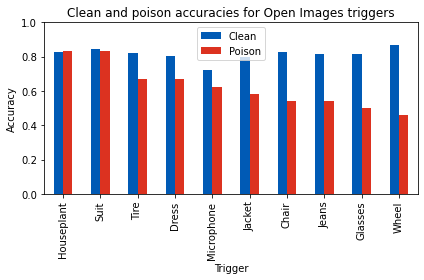

In [151]:
ax = df.sort_values(by='Poison', ascending=False).plot(kind="bar", color=['#005AB5', '#DC3220'])
ax.set_ylim([0, 1])
ax.set_title('Clean and poison accuracies for Open Images triggers')
ax.set_ylabel('Accuracy')
plt.tight_layout()

In [152]:
fig = ax.get_figure()
fig.savefig('oi_acc_chart.png')

In [137]:
!pwd

/home/rbhattacharjee1/ImageNet_backdoor
